In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
import math
import time

In [2]:
def plot_series_radar(df, names):
    labels=np.array(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'])
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))
    labels = np.concatenate((labels, [labels[0]]))

    indexes = []
    stats = []
    for name in names:
        indexes.append(df[df['Name'] == name].index[0])
        stats.append(list(df.loc[indexes[-1], labels].values))

    stats = [stat + stat[0] for stat in stats]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), subplot_kw=dict(polar=True))

    for stat, name in zip(stats, names):
        ax.plot(angles, stat, 'o-', linewidth=2, label=name)
        ax.fill(angles, stat, alpha=0.25)

    ax.set_thetagrids(angles * 180/np.pi, labels, fontsize=12, fontweight='bold')
    # ax.set_title(name)
    ax.grid(True)
    plt.legend(loc='center')
    ax.set_title('Radar của %s' % (', '.join(names)))
    plt.show()

In [3]:
df = pd.read_csv('pokemon.csv', index_col=0)
df

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...
796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True


In [4]:
df['Legendary'] = df['Legendary'].astype('int')

In [5]:
pokemon_types = sorted(df['Type 1'].unique())
print(pokemon_types)

['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']


In [6]:
def one_hot_modify(row):
    global pokemon_types
    datum = {i: 0 for i in pokemon_types}
    datum[row['Type 1']] = 1
    if isinstance(row['Type 2'], str):
        datum[row['Type 2']] = 1
    return [i for i in datum.values()]

In [7]:
df

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,0
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,0
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,0
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,0
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...,...,...
796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,1
797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,1
798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,1


In [8]:
one_hot_types = df.T.apply(one_hot_modify).T
one_hot_types.columns = pokemon_types
one_hot_types

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
#,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
797,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
798,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [9]:
pokemon = pd.concat([df, one_hot_types], axis=1).drop(['Type 1', 'Type 2', 'Name'], axis=1)
pokemon

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,...,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
#,,,,,,,,,,,,,,,,,,,,,
1,45,49,49,65,65,45,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,60,62,63,80,80,60,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,80,82,83,100,100,80,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,80,100,123,122,120,80,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
5,39,52,43,60,50,65,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,50,100,150,100,150,50,6,1,0,0,...,0,0,0,0,0,0,0,1,0,0
797,50,160,110,160,110,110,6,1,0,0,...,0,0,0,0,0,0,0,1,0,0
798,80,110,60,150,130,70,6,1,0,0,...,1,0,0,0,0,0,1,0,0,0


In [10]:
pokemon.reset_index().to_csv('preprocessed_pokemon.csv', index=False)

In [11]:
combat = pd.read_csv('combats.csv')
combat.columns = ['first', 'second', 'win']
combat

,first,second,win
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151
...,...,...,...
49995,707,126,707
49996,589,664,589
49997,303,368,368
49998,109,89,109


In [12]:
combat['winner'] = combat.T.apply(lambda x: x['second'] == x['win']).astype('int')

In [13]:
combat

,first,second,win,winner
0,266,298,298,1
1,702,701,701,1
2,191,668,668,1
3,237,683,683,1
4,151,231,151,0
...,...,...,...,...
49995,707,126,707,0
49996,589,664,589,0
49997,303,368,368,1
49998,109,89,109,0


In [14]:
def make_pokemon_data(dataframe, combatdata):
    data = []
    for idx, row in combatdata.iterrows():
        pokemon_1 = dataframe.loc[row['first']].values.tolist()
        pokemon_2 = dataframe.loc[row['second']].values.tolist()
        data.append(pokemon_1 + pokemon_2 + [row['winner']])
    return data

In [15]:
data = make_pokemon_data(pokemon, combat)

In [16]:
pokemon_columns = pokemon.columns
compose_columns = [col + '_1' for col in pokemon_columns]
compose_columns += [col + '_2' for col in pokemon_columns]
compose_columns += ['winner']
print(compose_columns)

['HP_1', 'Attack_1', 'Defense_1', 'Sp. Atk_1', 'Sp. Def_1', 'Speed_1', 'Generation_1', 'Legendary_1', 'Bug_1', 'Dark_1', 'Dragon_1', 'Electric_1', 'Fairy_1', 'Fighting_1', 'Fire_1', 'Flying_1', 'Ghost_1', 'Grass_1', 'Ground_1', 'Ice_1', 'Normal_1', 'Poison_1', 'Psychic_1', 'Rock_1', 'Steel_1', 'Water_1', 'HP_2', 'Attack_2', 'Defense_2', 'Sp. Atk_2', 'Sp. Def_2', 'Speed_2', 'Generation_2', 'Legendary_2', 'Bug_2', 'Dark_2', 'Dragon_2', 'Electric_2', 'Fairy_2', 'Fighting_2', 'Fire_2', 'Flying_2', 'Ghost_2', 'Grass_2', 'Ground_2', 'Ice_2', 'Normal_2', 'Poison_2', 'Psychic_2', 'Rock_2', 'Steel_2', 'Water_2', 'winner']


In [17]:
final_data = pd.DataFrame(data, columns=compose_columns)
final_data

,HP_1,Attack_1,Defense_1,Sp. Atk_1,Sp. Def_1,Speed_1,Generation_1,Legendary_1,Bug_1,Dark_1,...,Grass_2,Ground_2,Ice_2,Normal_2,Poison_2,Psychic_2,Rock_2,Steel_2,Water_2,winner
0,50,64,50,45,50,41,2,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,91,90,72,90,129,108,5,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,55,40,85,80,105,40,2,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,40,40,40,70,40,20,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,70,60,125,115,70,55,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,100,120,100,150,120,90,5,1,0,0,...,0,0,0,0,0,0,0,0,1,0
49996,60,85,40,30,45,68,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,60,50,100,85,70,65,3,0,0,0,...,0,0,0,1,0,0,0,0,0,1
49998,40,30,50,55,55,100,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
features = final_data.columns[:-1]
predict = final_data.columns[-1]
X = final_data[features].values
y = final_data[predict].values
X.shape, y.shape

((50000, 52), (50000,))

In [19]:
random_state = 10

In [20]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=random_state)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((40000, 52), (10000, 52), (40000,), (10000,))

In [21]:
# rf_params = dict(
#     n_estimators=[200],
#     criterion=['gini', 'entropy'],
#     max_depth=[None, 100],
#     min_samples_split=[2, 0.0001],
#     max_features=['sqrt', 'log2']
# )
# rf_params

In [22]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(Xtrain, ytrain)

RandomForestClassifier(n_estimators=300)

In [23]:
rf.score(Xtest, ytest)

0.9465

In [24]:
def make_combat_data(first, second):
    test_combat = pd.DataFrame({
        'first': [first],
        'second': [second],
        'winner': [0]
    })
    X = pd.DataFrame(make_pokemon_data(pokemon, test_combat), columns=compose_columns).drop('winner', axis=1).values
    return X

In [27]:
X_164_233 = make_combat_data(164, 233)
rf.predict(X_164_233)

array([0], dtype=int64)

In [29]:
X_233_164 = make_combat_data(233, 164)
rf.predict(X_233_164)

array([1], dtype=int64)

<AxesSubplot:>

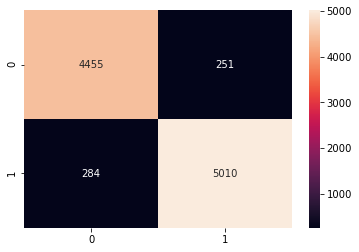

In [30]:
sns.heatmap(confusion_matrix(ytest, rf.predict(Xtest)), annot=True, fmt='.0f')

In [31]:
print('Dự đoán pokemon 1 thắng đúng: ', 7409 / Xtest.shape[0] * 100)
print('Dự đoán pokemon 2 thắng đúng: ', 8305 / Xtest.shape[0] * 100)

Dự đoán pokemon 1 thắng đúng:  74.09
Dự đoán pokemon 2 thắng đúng:  83.05


In [32]:
print('Những trận đấu pokemon 1 thắng nhưng lại dự đoán 2 thắng: ', 458 / Xtest.shape[0] * 100)
print('Những trận đấu pokemon 2 thắng nhưng lại dự đoán 1 thắng: ', 495 / Xtest.shape[0] * 100)

Những trận đấu pokemon 1 thắng nhưng lại dự đoán 2 thắng:  4.58
Những trận đấu pokemon 2 thắng nhưng lại dự đoán 1 thắng:  4.95


In [34]:
print(classification_report(ytest, rf.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      4706
           1       0.95      0.95      0.95      5294

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



Sau khi train mô hình 1 vs 1 thì ta có thể thấy được hiệu quả cao khi test trên bộ test. Bây giờ ta sẽ dùng mô hình này để đưa ra kết quả cho một cặp pokemon được đưa vào.

Bài toán ở đây đó là đấu đội. Một đội sẽ có 6 thành viên (6 pokemon, có thể trùng) đấu với đội khác (cũng có 6 pokemon). Vì lí do không thể mô phỏng, nên ta sẽ phải cho Pokemon đấu all-in. Nghĩa là có tổng cộng 36 trận đấu (1 pokemon sẽ đấu với 6 pokemon của đội khác). Cuối cùng sẽ đếm số lượng thắng cuộc của đội 1 và đội 2. Đội nào có số lượng thắng cao hơn trong trận đấu 12 Pokemon đó thì đội đó sẽ thắng. 

In [ ]:
def get_team_6():
    '''
    Hàm này sẽ trả về # của các Pokemon được random
    và dữ liệu của team
    '''
    return np.random.randint(1, 801, size=6)

In [ ]:
def combat_2_teams(team1, team2, model_1vs1):
    '''
    Hàm này
    '''
    start = time.time()
    total = 0
    for p1 in team1:
        for p2 in team2:
            total += model_1vs1.predict(make_combat_data(p1, p2))
    ret_data = {
        'team1': team1,
        'team2': team2,
        'winner': int(total >= 18)
    }
    print('Time for a match: %.2fs' % (time.time() - start))
    return ret_data

Tạo sẵn 100 team pokemon

In [ ]:
pokemon_teams = {}
for i in range(1, 101):
    pokemon_teams[i] = get_team_6()

Cho 100 team đấu với nhau

In [ ]:
start = time.time()
team_matches = []
for i in range(1, 101):
    for j in range(1, 101):
        idx_team1 = pokemon_teams[i]
        idx_team2 = pokemon_teams[j]
        winner = combat_2_teams(idx_team1, idx_team2, rf)
        team_matches.append(dict(first=i, second=j, winner=winner))
end = time.time()
print(end - time, ' second')

In [ ]:
team_combat = []
for data in team_matches:
    datum = dict(
        first=data['first'],
        second=data['second'],
        winner=data['winner']['winner']
    )
    team_combat += [datum]

Bộ dữ liệu này chứa id của các team và winner, nếu 1 thì là team 2 thắng, nếu 0 thì là team 1 thắng

In [ ]:
pd.DataFrame(team_combat).to_csv('team_combat.csv', index=False)

Mỗi team gồm có 6 thành viên, index từ 0 đến 5

`#` chính là id của team

In [ ]:
pd.DataFrame(pokemon_teams).T.reset_index().rename(columns={'index': '#'}).to_csv('pokemon_id_each_team.csv', index=False)

In [ ]:
for i in range(200):
    get_team_6()

In [ ]:
def pokemon(name):
    name = name.lower()
    img = plt.imread('assets/images/%s.png' % (name))
    plt.imshow(img)

In [ ]:
pokemon('Weedle')

# Hệ của Pokemon
![Pokemon type](assets/pokemon_type.png)

![type_attack](assets/typechart.png)

Giả sử mình có 2 con pokemon. Pokemon 1 $(p_1)$ Pokemon 2 $(p_2)$, trọng số của 2 pokemon là $w_1$ và $w_2$.

Giả sử hệ của $p_1$ là $t_1$, hệ của $p_2$ là $t_2$. Khi đó $w_1$ là tác động của $t_1$ $->$ $t_2$ và $w_2$ thì ngược lại.
Hệ quả khi 2 pokemon đánh nhau:


| Tham số | Công thức | Mô tả |
| ------- | --------- | ----- |
| final_atk_p1 | atk_p1 * (w1 * w2 (w2 này là hệ số của hệ thứ 2)) | Sức tấn công cơ bản cuối cùng |
| final_sp_atk_p1 | sp_atk_p1 * w1 | Sức tấn công cơ bản cuối cùng |
| final_def_p1 | def_p1 * w1 | Sức tấn công cơ bản cuối cùng |
| final_sp_def_p1 | sp_def_p1 * w1 | Sức tấn công cơ bản cuối cùng |

Tuần xây dựng mô hình. Từ các tỉ lệ hệ ở trên, máu, tốc độ, tấn công, dự đoán thử xem nếu đưa hai pokemon mới vào và dự đoán xem pokemon nào thắng.